# Welcome
To the notebook supporting the paper "Differences and Similarities in Jobs in the Data Domain" by Koen Bothmer. This paper and notebook were produced as an examination excercice for the class "Seminar: Current Topics in Data Science" at International University. This work was submitted to Turnitin but for the reference of those not involved in the class the paper was also included to the Github repository where this notebook can be found.

Please note that in order to reproduce the results as shown in the paper, it is only necessary to run the cells in section 1, 6, 7 and 8 of this notebook. The sections in between provide the web scraping functionality. It is recommended to only run these with permission of the website's owner.

## 1. Dependencies
When reproducing this work within the Docker container that can be recreated running the provided docker-compose.yml file all dependencies are guaranteed to be equal to those used by the author.

In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn_wordcloud import venn3_wordcloud
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Scraping Functions
The section of cells below provides all the functions needed to reproduce the dataset used in the paper. It is not necessary to rerun these cells as in the section "Load data from file" the dataset can be loaded into memory from a text file.

In [ ]:
def get_pages(search_term, page_count): #returns a list of search links given an input search term
    pages = []
    for page_no in range(page_count):
        page = 'https://www.indeed.com/jobs?q='+search_term+'&start='+str(page_no*10)
        pages.append(page)
    return pages

In [ ]:
def get_links(search_link): #Takes in one search page and returns all job links on the page
    links = []
    page = requests.get(search_link)
    search_soup = BeautifulSoup(page.text)
    mydivs = search_soup.find_all("div", {"class": "jobsearch-SerpJobCard unifiedRow row result"})
    for div in mydivs:
        link = 'https://www.indeed.com/viewjob?jk='+div.get('data-jk')
        links.append(link)
    return links

In [ ]:
def get_content(url): #Takes in a job link and returns all list elements of all unordered lists in the section "jobDescriptionText"
    content = []
    page = requests.get(url)
    search_soup = BeautifulSoup(page.text)
    #uls = search_soup.find_all("ul")
    divs = search_soup.find_all("div",{"id": "jobDescriptionText"})
    for div in divs:
        uls = div.find_all("ul")
        for ul in uls:
            for li in ul.find_all('li'):
                content.append(li.text)
    return content
    

In [ ]:
def get_content_list(urls): #Runs get_content on a list of urls returning one list of unordered list's items for multiple postings
    content = []
    for url in urls:
        content.append(get_content(url))
    return content


## 3. Data cleaning

In [ ]:
def preprocess(data): #preprocesses data outputed by get_content_list
    content_list = []
    for list in data:
        for word in list:
            content_list.append(word)
    cleaned_list = []
    for string in content_list:
        string = string.lower()
        string = string.strip("\n.’:")
        string = string.strip("’")
        string = string.strip(".")
        string = string.replace(",","")
        string = string.replace("/"," ")
        string = string.replace("(","")
        string = string.replace(")","")
        string = string.replace(";","")
        string = string.replace("etc","")
        string = string.replace("e.g","")
        string = string.replace("’","")
        
        string = word_tokenize(string)
        for w in string:
            if not w in stop_words:
                cleaned_list.append(w)
    return(cleaned_list)

In [ ]:
def get_word_count(search_term): #Bringing all functions together
    pages = get_pages(search_term,5)
    job_links = []
    for page in pages:
        job_links.append(get_links(page))
    job_links = [i for sublist in job_links for i in sublist]#flatten the list of lists
    jobs_content = get_content_list(job_links)
    cleaned_jobs_content = preprocess(jobs_content)
    word_count = Counter(cleaned_jobs_content)
    bigrams = zip(cleaned_jobs_content,cleaned_jobs_content[1:])
    bigrams_count = Counter(bigrams)
    return(cleaned_jobs_content, word_count, bigrams_count)

## 4. Get scraper results
It is recommended to only run the lines below when needed. These do the actual data scraping on the web. All results discussed in the paper are saved to the text file "dump_de_ds_da.txt" and can be loaded in the "Load data from file" section.

In [ ]:
data_engineer_data_dl = get_word_count('data+engineer')

In [ ]:
data_scientist_data_dl = get_word_count('data+scientist')

In [ ]:
data_analyst_data_dl = get_word_count('data+analyst')

## 5. Writing scraped data to text file
In order to not scrape unecessary the data is saved to a text file. This functionality can be used to easily store results over time for further analysis beyond the scope of the paper.

In [ ]:
file = open('dump.txt', 'wb')
pickle.dump([data_engineer_data_dl, data_scientist_data_dl, data_analyst_data_dl], file)
file.close()

## 6. Reading the text file into memory
The file provided in the Github repository can be read into memory to reproduce the results of the author that were found running the scraper 30-4-2021.

In [2]:
#Run from here to get the exact results discussed in paper
file = open('dump_de_ds_da.txt', 'rb')
list = pickle.load(file)

data_engineer_data = list[0]
data_scientist_data = list[1]
data_analyst_data = list[2]

## 7. Data Visualization

In [3]:
def plot_counter(counter,image_name):
    x = [word[0] for word in counter.most_common(20)]
    y = [counter[word] for word in x]
    fig = plt.figure(figsize = (25,15))
    plt.bar(x,y)
    plt.xticks(fontsize=25, rotation=45, ha="right")
    plt.yticks(fontsize=25)
    plt.xlabel("Word Categories", fontsize =25)
    plt.ylabel("Category Count", fontsize =25)
    plt.savefig(image_name+".pdf")
    plt.show()

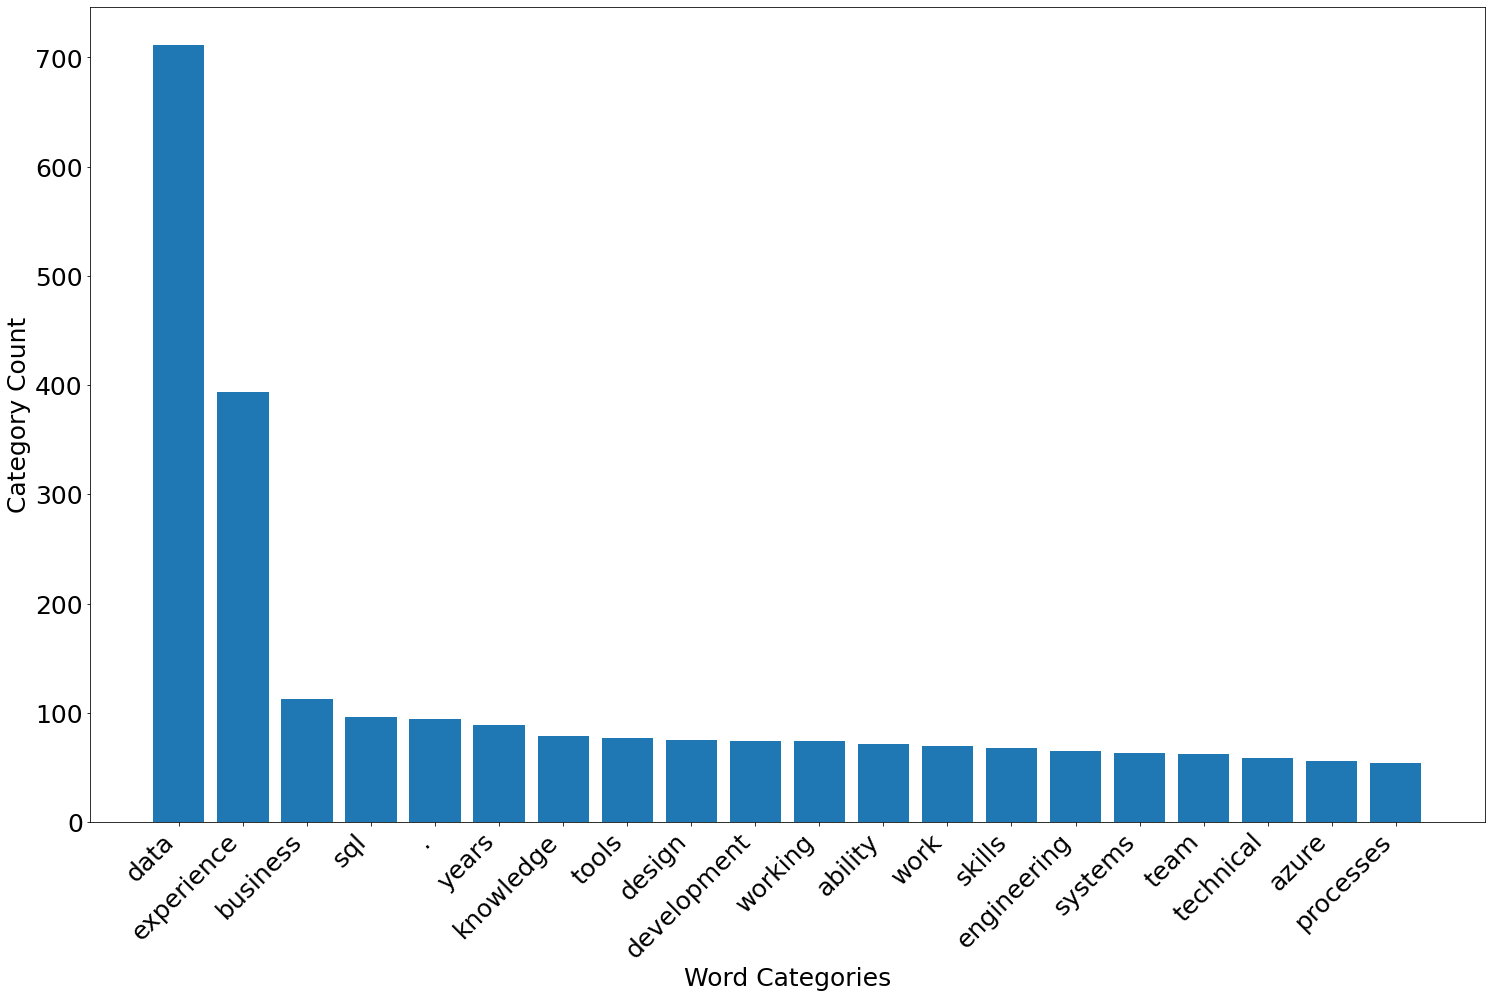

In [4]:
plot_counter(data_engineer_data[1],"data_engineer_single_word_counter")

In [5]:
def plot_bigram_counter(counter,image_name):
    c = [word[0] for word in counter.most_common(20)]
    x = [str(bigram[0])+" "+str(bigram[1]) for bigram in counter.most_common(20)]
    y = [counter[word] for word in c]
    fig = plt.figure(figsize = (25,15))
    plt.xticks(rotation=30, ha="right", fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.xlabel("Bigram Categories", fontsize =25)
    plt.ylabel("Category Count", fontsize =25)
    plt.bar(x,y)
    plt.tight_layout()
    plt.savefig(image_name+".pdf")
    plt.show()

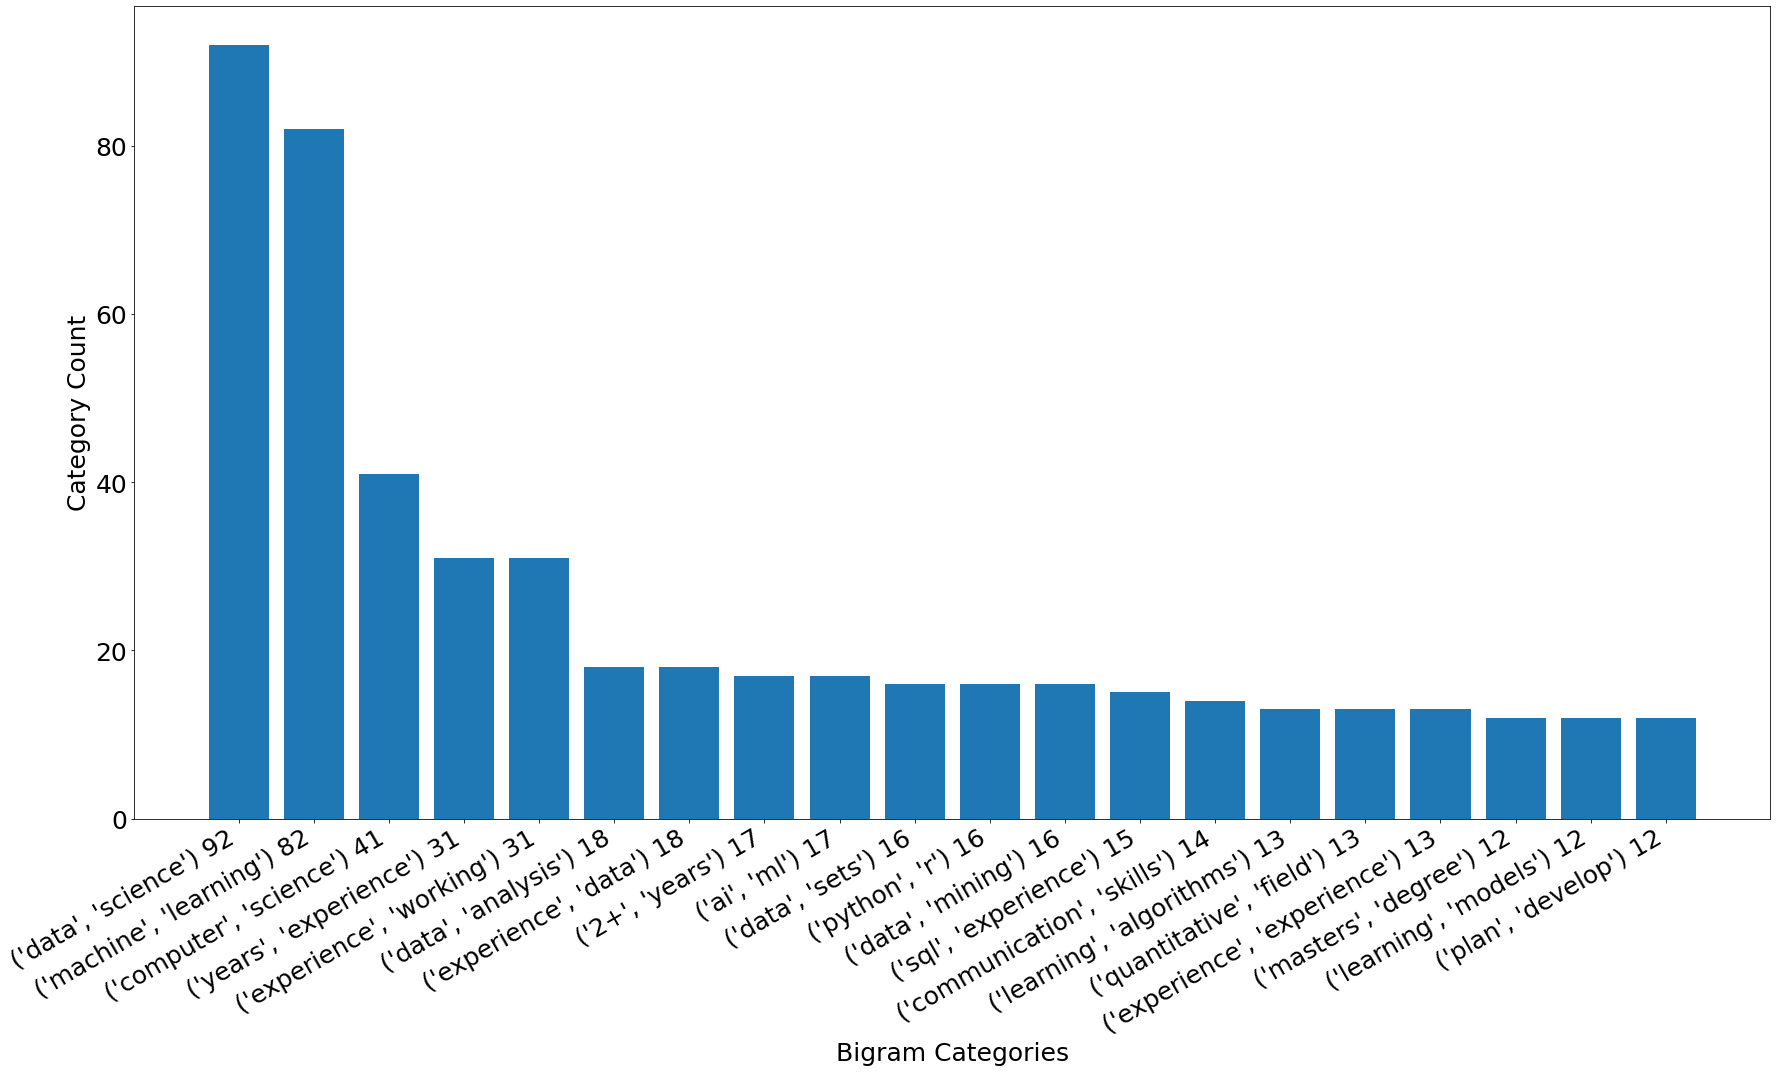

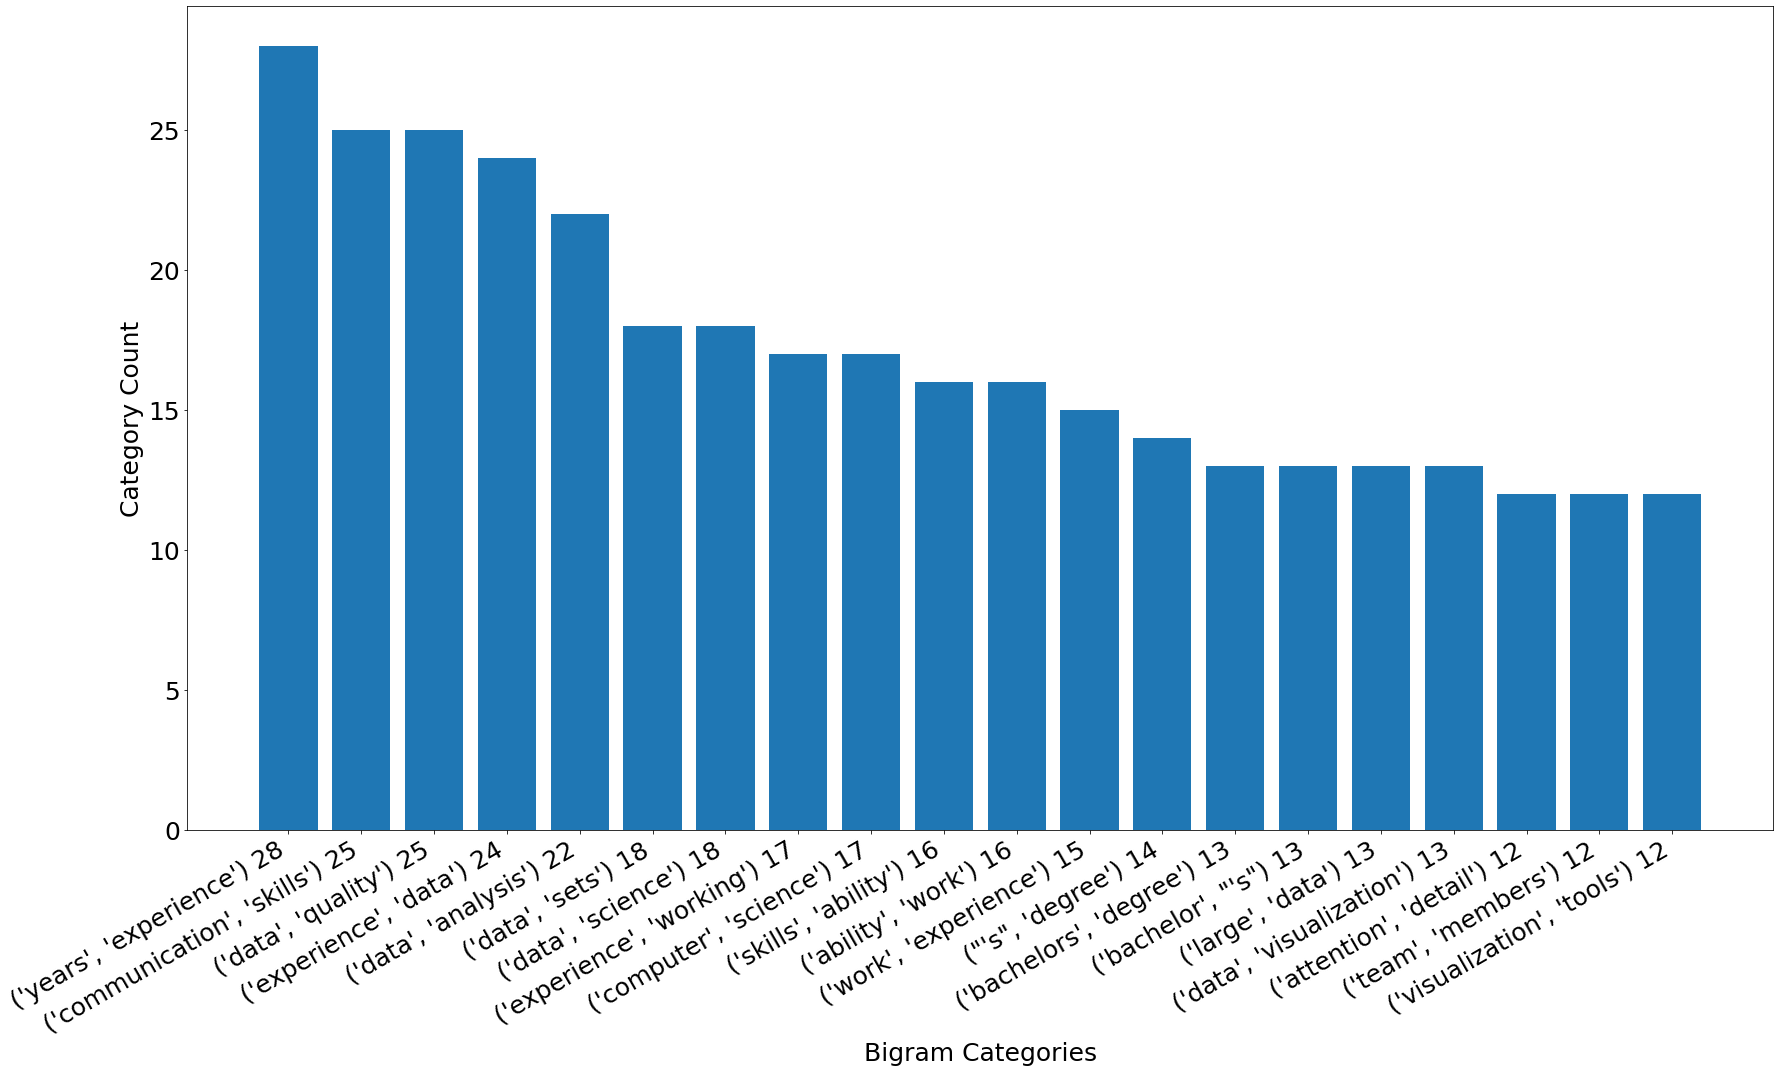

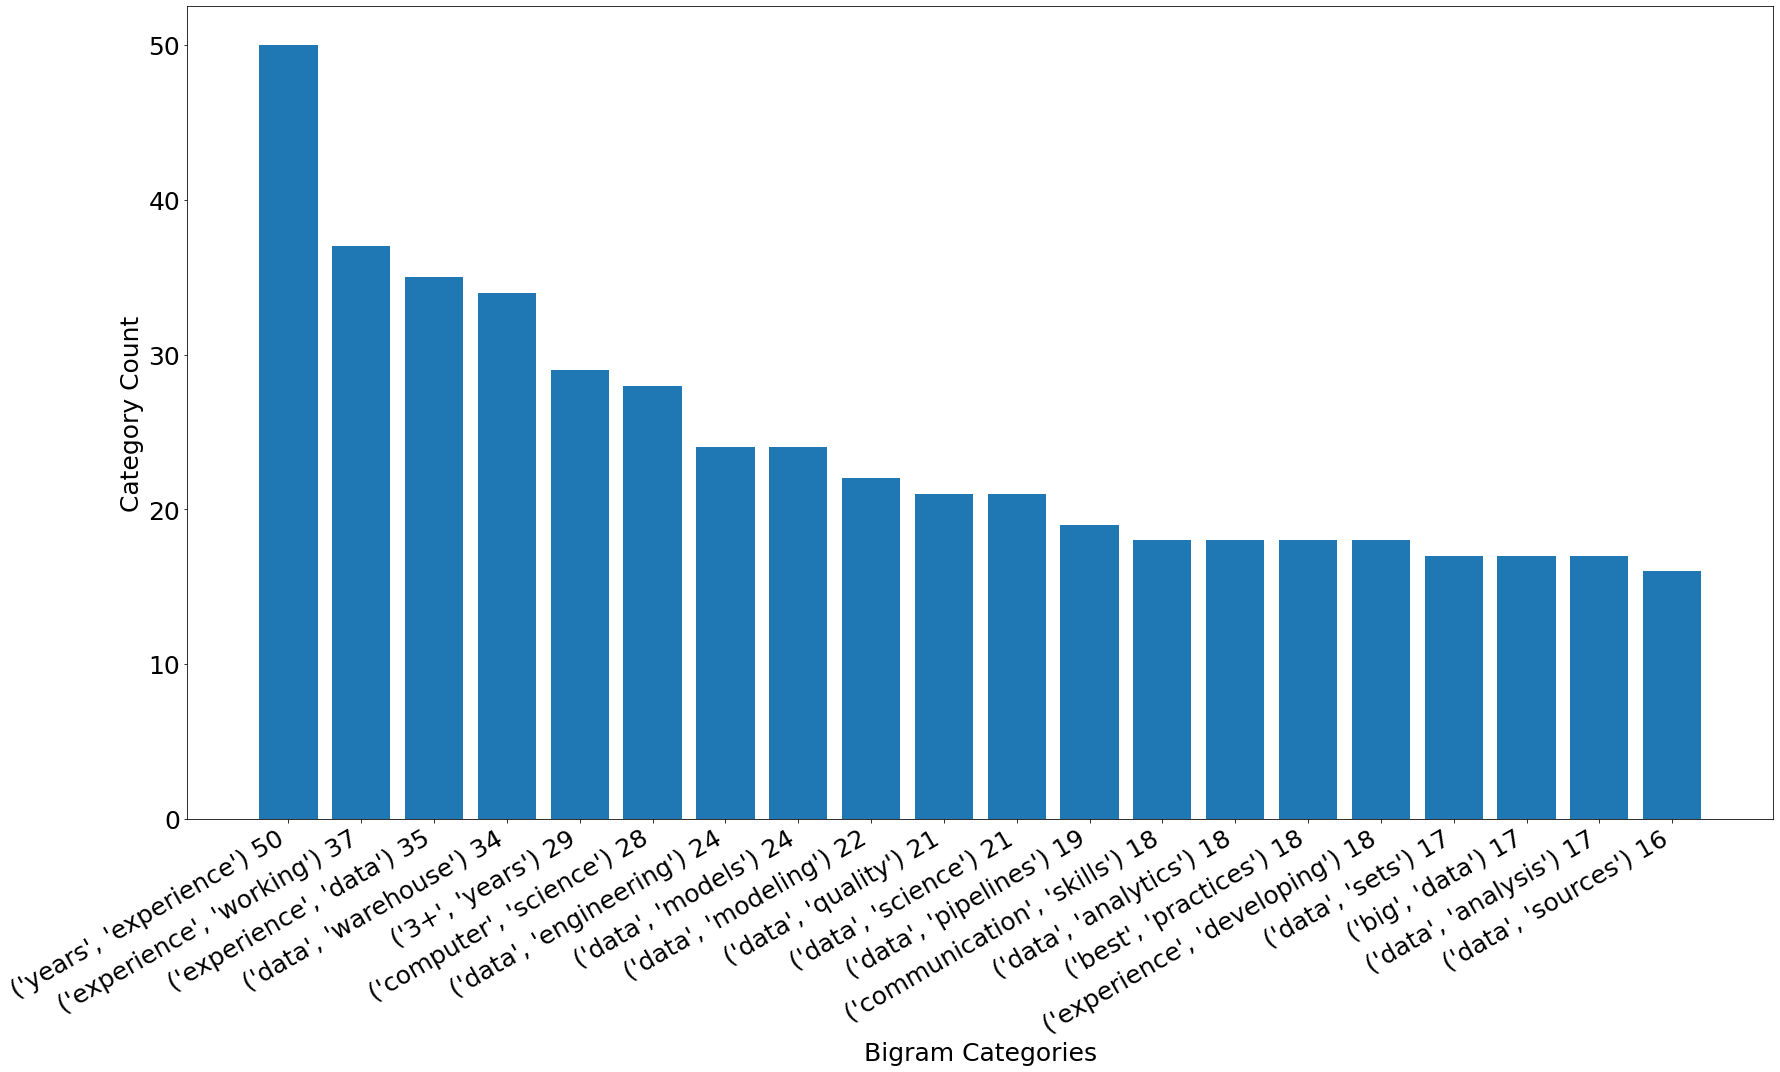

In [6]:
plot_bigram_counter(data_scientist_data[2], "data_scientist_bigram_count")
plot_bigram_counter(data_analyst_data[2], "data_analyst_bigram_count")
plot_bigram_counter(data_engineer_data[2], "data_engineer_bigram_count")

## 8. Venn Diagram
The most common 30 bigrams for each job category are stored in lists which are turned into sets. 
The label naming convention used for the label id's in the venn3 class is binary, each bit represents an input set, 1 includes and 0 excludes. 111 for example is the union of all sets (center). 100 is the disjoint set of Data Scientist bigrams (red).

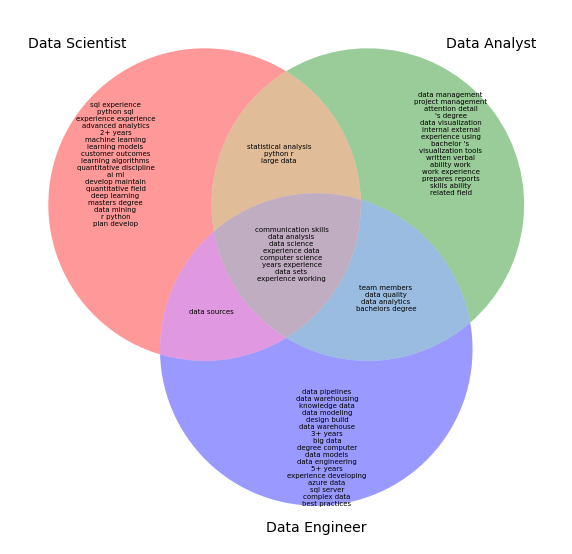

In [7]:
ds = []
for t in data_scientist_data[2].most_common(30):
    ds.append(t[0][0]+" "+t[0][1])
da = []
for t in data_analyst_data[2].most_common(30):
    da.append(t[0][0]+" "+t[0][1])
de = []
for t in data_engineer_data[2].most_common(30):
    de.append(t[0][0]+" "+t[0][1])
    
ds_set = set(ds)
da_set = set(da)
de_set = set(de)

plt.figure(figsize=(10,10))
#plt.tight_layout()

v = venn3([ds_set,da_set,de_set], ('Data Scientist', 'Data Analyst', 'Data Engineer'))

for text in v.set_labels:
    text.set_fontsize(14)
for text in v.subset_labels:
    text.set_fontsize(7)

v.get_label_by_id('100').set_text('\n'.join(ds_set-da_set-de_set))
v.get_label_by_id('110').set_text('\n'.join(ds_set&da_set-de_set))
v.get_label_by_id('111').set_text('\n'.join(ds_set&da_set&de_set))
v.get_label_by_id('101').set_text('\n'.join(ds_set&de_set-da_set))
v.get_label_by_id('011').set_text('\n'.join(da_set&de_set-ds_set))
v.get_label_by_id('010').set_text('\n'.join(da_set-de_set-ds_set))
v.get_label_by_id('001').set_text('\n'.join(de_set-da_set-ds_set))

plt.savefig("Venn.pdf",bbox_inches='tight')